In [64]:
import pandas as pd
import xml.etree.cElementTree as ET
import os.path
import itertools
import collections
import re
import numpy as np
import seaborn as sns
import nltk
import xgboost as xgb
import pickle
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
#from nltk import WordNetLemmatizer


In [2]:
data = pd.read_csv('SearchResults.csv')
data.head(10)

,Rank,NCT Number,Title,Acronym,Status,Study Results,Interventions,Phases,Results First Posted,URL
0,1,NCT02266147,Study of SD-101 in Combination With Localized ...,NaN,Completed,No Results Available,Drug: SD-101|Radiation: Radiation therapy,Phase 1|Phase 2,NaN,https://ClinicalTrials.gov/show/NCT02266147
1,2,NCT02055924,Bruton's Tyrosine Kinase (BTK) Inhibition in B...,BIBLOS,Terminated,No Results Available,Drug: Ibrutinib and immunochemotherapies,Phase 1,NaN,https://ClinicalTrials.gov/show/NCT02055924
2,3,NCT02395601,A Study Evaluating CPI-1205 in Patients With B...,NaN,"Active, not recruiting",No Results Available,Drug: CPI-1205,Phase 1,NaN,https://ClinicalTrials.gov/show/NCT02395601
3,4,NCT00162656,Treatment of Mature B-cell Lymphoma/Leukaemia,NaN,Completed,No Results Available,Drug: half cyclophosphamide|Drug: without COPA...,Phase 3,NaN,https://ClinicalTrials.gov/show/NCT00162656
4,5,NCT03424122,"INCB050465 in Combination With Rituximab, Bend...",NaN,Recruiting,No Results Available,Drug: INCB050465|Drug: Rituximab|Drug: Bendamu...,Phase 1,NaN,https://ClinicalTrials.gov/show/NCT03424122
5,6,NCT02247609,Evaluation of 4th Generation Safety-designed C...,4SCAR19273,Unknown status,No Results Available,Genetic: Anti-CD19 CAR T cells,Phase 1|Phase 2,NaN,https://ClinicalTrials.gov/show/NCT02247609
6,7,NCT01478269,Prognosis Of Patients With Aggressive B-Cell L...,ProDLBCL,Completed,No Results Available,NaN,NaN,NaN,https://ClinicalTrials.gov/show/NCT01478269
7,8,NCT03664336,Refractory Diffuse Large B-cell Lymphoma,NaN,Completed,No Results Available,NaN,NaN,NaN,https://ClinicalTrials.gov/show/NCT03664336
8,9,NCT03258047,Novel Autologou CAR-T Therapy for Relapsed/Ref...,NaN,Recruiting,No Results Available,Combination Product: CAR-T,Phase 2,NaN,https://ClinicalTrials.gov/show/NCT03258047
9,10,NCT02433795,Bendamustine Plus Rituximab (BR) for Relapsed ...,NaN,"Active, not recruiting",No Results Available,Drug: bendamustine plus rituximab,Phase 2,NaN,https://ClinicalTrials.gov/show/NCT02433795


In [3]:
def get_title(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    for child in root:
        if child.tag == 'official_title':
            return child.text

In [4]:
title_list = []

for nct in data['NCT Number']:
    file_name = nct + '.xml'
    file_path = os.path.join('search_result', file_name)
    try:
        title_list.append(get_title(file_path))
    except:
        title_list.append(np.nan)

In [5]:
data['Official Title'] = title_list

In [6]:
data = data.drop(['Acronym', 'Status', 'Rank', 'Study Results', 'Results First Posted', 'URL'], axis = 1)

In [7]:
data.head(10)

,NCT Number,Title,Interventions,Phases,Official Title
0,NCT02266147,Study of SD-101 in Combination With Localized ...,Drug: SD-101|Radiation: Radiation therapy,Phase 1|Phase 2,"A Phase 1/2, Non-randomized, Open-label, Multi..."
1,NCT02055924,Bruton's Tyrosine Kinase (BTK) Inhibition in B...,Drug: Ibrutinib and immunochemotherapies,Phase 1,A Phase Ib Study of Ibrutinib Combined With R-...
2,NCT02395601,A Study Evaluating CPI-1205 in Patients With B...,Drug: CPI-1205,Phase 1,"A Phase 1 Study of CPI-1205, a Small Molecule ..."
3,NCT00162656,Treatment of Mature B-cell Lymphoma/Leukaemia,Drug: half cyclophosphamide|Drug: without COPA...,Phase 3,Treatment of Mature B-cell Lymphoma/Leukaemia ...
4,NCT03424122,"INCB050465 in Combination With Rituximab, Bend...",Drug: INCB050465|Drug: Rituximab|Drug: Bendamu...,Phase 1,NaN
5,NCT02247609,Evaluation of 4th Generation Safety-designed C...,Genetic: Anti-CD19 CAR T cells,Phase 1|Phase 2,Safety and Efficacy Evaluation of 4th Generati...
6,NCT01478269,Prognosis Of Patients With Aggressive B-Cell L...,NaN,NaN,Prognosis Of Patients With Aggressive B-Cell L...
7,NCT03664336,Refractory Diffuse Large B-cell Lymphoma,NaN,NaN,NaN
8,NCT03258047,Novel Autologou CAR-T Therapy for Relapsed/Ref...,Combination Product: CAR-T,Phase 2,NaN
9,NCT02433795,Bendamustine Plus Rituximab (BR) for Relapsed ...,Drug: bendamustine plus rituximab,Phase 2,A Phase II Study of Bendamustine Plus Rituxima...


In [8]:
data.dropna(inplace = True)

In [9]:
data.head(10)

,NCT Number,Title,Interventions,Phases,Official Title
0,NCT02266147,Study of SD-101 in Combination With Localized ...,Drug: SD-101|Radiation: Radiation therapy,Phase 1|Phase 2,"A Phase 1/2, Non-randomized, Open-label, Multi..."
1,NCT02055924,Bruton's Tyrosine Kinase (BTK) Inhibition in B...,Drug: Ibrutinib and immunochemotherapies,Phase 1,A Phase Ib Study of Ibrutinib Combined With R-...
2,NCT02395601,A Study Evaluating CPI-1205 in Patients With B...,Drug: CPI-1205,Phase 1,"A Phase 1 Study of CPI-1205, a Small Molecule ..."
3,NCT00162656,Treatment of Mature B-cell Lymphoma/Leukaemia,Drug: half cyclophosphamide|Drug: without COPA...,Phase 3,Treatment of Mature B-cell Lymphoma/Leukaemia ...
5,NCT02247609,Evaluation of 4th Generation Safety-designed C...,Genetic: Anti-CD19 CAR T cells,Phase 1|Phase 2,Safety and Efficacy Evaluation of 4th Generati...
9,NCT02433795,Bendamustine Plus Rituximab (BR) for Relapsed ...,Drug: bendamustine plus rituximab,Phase 2,A Phase II Study of Bendamustine Plus Rituxima...
11,NCT02547948,CD19-targeting CAR T Cells for B Cell Lymphoma,Biological: CD19-targeting CAR T Cells infusion,Phase 1|Phase 2,CD19-targeting CAR T Cells for Refractory B Ce...
19,NCT02060656,Phase II Study Comparing LR-GEM to R-GEM-P in ...,Drug: Gemcitabine|Drug: Methylprednisolone|Dru...,Phase 2,A Randomised Phase II Study Comparing LEnalido...
20,NCT01068392,Oxaliplatin and Prednisolone (Ox-P) for Patien...,"Drug: Oxaliplatin, Prednisolone",Phase 2,A Phase II Study of Oxaliplatin and Prednisolo...
21,NCT02531308,Metformin in Combination With Standard Inducti...,Drug: Metformin|Drug: Rituximab|Drug: Cyclopho...,Phase 2,A Phase ll Study Evaluating the Efficacy and S...


In [10]:
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [11]:
data['Title'] = data['Title'].apply(stemming)
data['Official Title'] = data['Official Title'].apply(str).apply(stemming)

In [12]:
data.head(5)

,NCT Number,Title,Interventions,Phases,Official Title
0,NCT02266147,studi of sd-101 in combin with local low-dos r...,Drug: SD-101|Radiation: Radiation therapy,Phase 1|Phase 2,"a phase 1/2, non-randomized, open-label, multi..."
1,NCT02055924,bruton tyrosin kinas (btk) inhibit in b-cell l...,Drug: Ibrutinib and immunochemotherapies,Phase 1,a phase ib studi of ibrutinib combin with r-dh...
2,NCT02395601,a studi evalu cpi-1205 in patient with b-cell ...,Drug: CPI-1205,Phase 1,"a phase 1 studi of cpi-1205, a small molecul i..."
3,NCT00162656,treatment of matur b-cell lymphoma/leukaemia,Drug: half cyclophosphamide|Drug: without COPA...,Phase 3,treatment of matur b-cell lymphoma/leukaemia a...
5,NCT02247609,evalu of 4th generat safety-design car t cell ...,Genetic: Anti-CD19 CAR T cells,Phase 1|Phase 2,safeti and efficaci evalu of 4th generat safet...


In [13]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [14]:
data['Title'] = data['Title'].apply(remove_punctuation)
data['Official Title'] = data['Official Title'].apply(remove_punctuation)

In [15]:
data.head(5)

,NCT Number,Title,Interventions,Phases,Official Title
0,NCT02266147,studi of sd101 in combin with local lowdos rad...,Drug: SD-101|Radiation: Radiation therapy,Phase 1|Phase 2,a phase 12 nonrandomized openlabel multicenter...
1,NCT02055924,bruton tyrosin kinas btk inhibit in bcell lymp...,Drug: Ibrutinib and immunochemotherapies,Phase 1,a phase ib studi of ibrutinib combin with rdha...
2,NCT02395601,a studi evalu cpi1205 in patient with bcell ly...,Drug: CPI-1205,Phase 1,a phase 1 studi of cpi1205 a small molecul inh...
3,NCT00162656,treatment of matur bcell lymphomaleukaemia,Drug: half cyclophosphamide|Drug: without COPA...,Phase 3,treatment of matur bcell lymphomaleukaemia a s...
5,NCT02247609,evalu of 4th generat safetydesign car t cell t...,Genetic: Anti-CD19 CAR T cells,Phase 1|Phase 2,safeti and efficaci evalu of 4th generat safet...


In [16]:
def remove_plus(interventions):
    interventions = re.sub(' and ', ', ', interventions)
    interventions = re.sub(' plus ', ', ', interventions)
    interventions = re.sub(' \+ ', ', ', interventions)
    return interventions

In [17]:
def get_drugs(interventions):
    interventions = remove_plus(interventions)
    drugs = [x.split(', ') for x in re.findall('drug: (\w+-*\w+[, \w+]*)', interventions)]
    flat_drugs = [item for sublist in drugs for item in sublist]
    return flat_drugs

In [18]:
def get_phase(phases):
    phase = re.findall('Phase (\d)', phases)
    return phase

In [19]:
data['Interventions'] = data['Interventions'].apply(lambda x: x.lower())
data['Interventions'] = data['Interventions'].apply(get_drugs)
data['Phases'] = data['Phases'].apply(get_phase)

In [20]:
data.head(10)

,NCT Number,Title,Interventions,Phases,Official Title
0,NCT02266147,studi of sd101 in combin with local lowdos rad...,[sd-101],"[1, 2]",a phase 12 nonrandomized openlabel multicenter...
1,NCT02055924,bruton tyrosin kinas btk inhibit in bcell lymp...,"[ibrutinib, immunochemotherapies]",[1],a phase ib studi of ibrutinib combin with rdha...
2,NCT02395601,a studi evalu cpi1205 in patient with bcell ly...,[cpi-1205],[1],a phase 1 studi of cpi1205 a small molecul inh...
3,NCT00162656,treatment of matur bcell lymphomaleukaemia,"[half cyclophosphamide, without copadm3, mini ...",[3],treatment of matur bcell lymphomaleukaemia a s...
5,NCT02247609,evalu of 4th generat safetydesign car t cell t...,[],"[1, 2]",safeti and efficaci evalu of 4th generat safet...
9,NCT02433795,bendamustin plus rituximab br for relaps or pr...,"[bendamustine, rituximab]",[2],a phase ii studi of bendamustin plus rituximab...
11,NCT02547948,cd19target car t cell for b cell lymphoma,[],"[1, 2]",cd19target car t cell for refractori b cell ly...
19,NCT02060656,phase ii studi compar lrgem to rgemp in second...,"[gemcitabine, methylprednisolone, rituximab, c...",[2],a randomis phase ii studi compar lenalidomid p...
20,NCT01068392,oxaliplatin and prednisolon oxp for patient wi...,"[oxaliplatin, prednisolone]",[2],a phase ii studi of oxaliplatin and prednisolo...
21,NCT02531308,metformin in combin with standard induct thera...,"[metformin, rituximab, cyclophosphamide, doxor...",[2],a phase ll studi evalu the efficaci and safeti...


In [21]:
data = data[data['Interventions'].map(lambda d: len(d)) > 0]
data = data[data['Phases'].map(lambda d: len(d)) > 0]

In [22]:
data.head(10)

,NCT Number,Title,Interventions,Phases,Official Title
0,NCT02266147,studi of sd101 in combin with local lowdos rad...,[sd-101],"[1, 2]",a phase 12 nonrandomized openlabel multicenter...
1,NCT02055924,bruton tyrosin kinas btk inhibit in bcell lymp...,"[ibrutinib, immunochemotherapies]",[1],a phase ib studi of ibrutinib combin with rdha...
2,NCT02395601,a studi evalu cpi1205 in patient with bcell ly...,[cpi-1205],[1],a phase 1 studi of cpi1205 a small molecul inh...
3,NCT00162656,treatment of matur bcell lymphomaleukaemia,"[half cyclophosphamide, without copadm3, mini ...",[3],treatment of matur bcell lymphomaleukaemia a s...
9,NCT02433795,bendamustin plus rituximab br for relaps or pr...,"[bendamustine, rituximab]",[2],a phase ii studi of bendamustin plus rituximab...
19,NCT02060656,phase ii studi compar lrgem to rgemp in second...,"[gemcitabine, methylprednisolone, rituximab, c...",[2],a randomis phase ii studi compar lenalidomid p...
20,NCT01068392,oxaliplatin and prednisolon oxp for patient wi...,"[oxaliplatin, prednisolone]",[2],a phase ii studi of oxaliplatin and prednisolo...
21,NCT02531308,metformin in combin with standard induct thera...,"[metformin, rituximab, cyclophosphamide, doxor...",[2],a phase ll studi evalu the efficaci and safeti...
26,NCT00097929,an investig drug studi with suberoylanilid hyd...,"[mk0683, vorinostat, suberoylanilide hydroxami...",[2],a phase ii clinic trial of oral suberoylanilid...
27,NCT01226849,feasibl studi of ad bortezomib to rice chemoth...,"[bortezomib, rituximab, ifosphamide, etoposide...",[1],an openlabel pilot studi to investig feasibl a...


In [23]:
util_data = data.drop(['Title','Official Title'], axis = 1)

In [24]:
util_data.head(10)

,NCT Number,Interventions,Phases
0,NCT02266147,[sd-101],"[1, 2]"
1,NCT02055924,"[ibrutinib, immunochemotherapies]",[1]
2,NCT02395601,[cpi-1205],[1]
3,NCT00162656,"[half cyclophosphamide, without copadm3, mini ...",[3]
9,NCT02433795,"[bendamustine, rituximab]",[2]
19,NCT02060656,"[gemcitabine, methylprednisolone, rituximab, c...",[2]
20,NCT01068392,"[oxaliplatin, prednisolone]",[2]
21,NCT02531308,"[metformin, rituximab, cyclophosphamide, doxor...",[2]
26,NCT00097929,"[mk0683, vorinostat, suberoylanilide hydroxami...",[2]
27,NCT01226849,"[bortezomib, rituximab, ifosphamide, etoposide...",[1]


In [25]:
util_data.to_pickle('util_data.pkl')

In [26]:
def get_cosine_sim(*strs): 
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)
    
def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

In [27]:
nct1 = []
nct2 = []
interv1 = []
interv2 = []
phase1 = []
phase2 = []
cos = []
count = 0

In [28]:
for id1, id2 in itertools.combinations(data.index, 2):
    count += 1
    if count%100000 == 0:
        print(count)
    nct1.append(data['NCT Number'][id1])
    nct2.append(data['NCT Number'][id2])
    interv1.append(data['Interventions'][id1])
    interv2.append(data['Interventions'][id2])
    phase1.append(data['Phases'][id1])
    phase2.append(data['Phases'][id2])
    cos.append(get_cosine_sim(data['Official Title'][id1], data['Official Title'][id2])[0][1])

100000
200000
300000
400000
500000
600000


In [29]:
pair_data = pd.DataFrame({'NCT Number 1' : nct1, 'NCT Number 2' : nct2, 'Interventions 1' : interv1, 'Interventions 2' : interv2,
                         'Phases 1' : phase1, 'Phases 2' : phase2, 'Cosine Distance' : cos})

In [30]:
pair_data.head(10)

,NCT Number 1,NCT Number 2,Interventions 1,Interventions 2,Phases 1,Phases 2,Cosine Distance
0,NCT02266147,NCT02055924,[sd-101],"[ibrutinib, immunochemotherapies]","[1, 2]",[1],0.582323
1,NCT02266147,NCT02395601,[sd-101],[cpi-1205],"[1, 2]",[1],0.557370
2,NCT02266147,NCT00162656,[sd-101],"[half cyclophosphamide, without copadm3, mini ...","[1, 2]",[3],0.190261
3,NCT02266147,NCT02433795,[sd-101],"[bendamustine, rituximab]","[1, 2]",[2],0.432789
4,NCT02266147,NCT02060656,[sd-101],"[gemcitabine, methylprednisolone, rituximab, c...","[1, 2]",[2],0.294118
5,NCT02266147,NCT01068392,[sd-101],"[oxaliplatin, prednisolone]","[1, 2]",[2],0.404226
6,NCT02266147,NCT02531308,[sd-101],"[metformin, rituximab, cyclophosphamide, doxor...","[1, 2]",[2],0.445896
7,NCT02266147,NCT00097929,[sd-101],"[mk0683, vorinostat, suberoylanilide hydroxami...","[1, 2]",[2],0.393445
8,NCT02266147,NCT01226849,[sd-101],"[bortezomib, rituximab, ifosphamide, etoposide...","[1, 2]",[1],0.388922
9,NCT02266147,NCT00801216,[sd-101],"[high-dose sequential chemotherapy, autologous...","[1, 2]",[2],0.342997


/home/daniil_chuykin/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


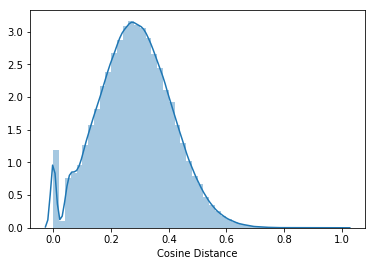

In [31]:
sns.distplot(pair_data['Cosine Distance'])

In [32]:
counter = 0
for index in pair_data.index:
    counter += 1
    if counter % 100000 == 0:
        print(counter)
    if pair_data.loc[index,'Cosine Distance'] > 0.5:
        pair_data.loc[index,'Is Similar'] = 1
    else:
        pair_data.loc[index, 'Is Similar'] = 0

100000
200000
300000
400000
500000
600000


In [33]:

pair_data.head(30)

,NCT Number 1,NCT Number 2,Interventions 1,Interventions 2,Phases 1,Phases 2,Cosine Distance,Is Similar
0,NCT02266147,NCT02055924,[sd-101],"[ibrutinib, immunochemotherapies]","[1, 2]",[1],0.582323,1.0
1,NCT02266147,NCT02395601,[sd-101],[cpi-1205],"[1, 2]",[1],0.557370,1.0
2,NCT02266147,NCT00162656,[sd-101],"[half cyclophosphamide, without copadm3, mini ...","[1, 2]",[3],0.190261,0.0
3,NCT02266147,NCT02433795,[sd-101],"[bendamustine, rituximab]","[1, 2]",[2],0.432789,0.0
4,NCT02266147,NCT02060656,[sd-101],"[gemcitabine, methylprednisolone, rituximab, c...","[1, 2]",[2],0.294118,0.0
5,NCT02266147,NCT01068392,[sd-101],"[oxaliplatin, prednisolone]","[1, 2]",[2],0.404226,0.0
6,NCT02266147,NCT02531308,[sd-101],"[metformin, rituximab, cyclophosphamide, doxor...","[1, 2]",[2],0.445896,0.0
7,NCT02266147,NCT00097929,[sd-101],"[mk0683, vorinostat, suberoylanilide hydroxami...","[1, 2]",[2],0.393445,0.0
8,NCT02266147,NCT01226849,[sd-101],"[bortezomib, rituximab, ifosphamide, etoposide...","[1, 2]",[1],0.388922,0.0
9,NCT02266147,NCT00801216,[sd-101],"[high-dose sequential chemotherapy, autologous...","[1, 2]",[2],0.342997,0.0


In [34]:
pair_data.shape

(641278, 8)

In [35]:
binarize = MultiLabelBinarizer()


In [36]:
train_data = pd.DataFrame(binarize.fit_transform(pair_data['Phases 1']), columns = 'Is 1st phase ' + binarize.classes_, index = pair_data.index)

In [37]:
train_data = train_data.join(pd.DataFrame(binarize.fit_transform(pair_data['Interventions 1']), columns = 'Is 1st ' + binarize.classes_, index = pair_data.index))

In [38]:
train_data = train_data.join(pd.DataFrame(binarize.fit_transform(pair_data['Phases 2']), columns = 'Is 2nd phase  ' + binarize.classes_, index = pair_data.index))
train_data = train_data.join(pd.DataFrame(binarize.fit_transform(pair_data['Interventions 2']), columns = 'Is 2nd ' + binarize.classes_, index = pair_data.index))

In [39]:
Y = pair_data['Is Similar']

In [40]:
train_data.head(20)

,Is 1st phase 1,Is 1st phase 2,Is 1st phase 3,Is 1st phase 4,Is 1st 10,Is 1st 1018 iss,Is 1st 111in ibritumomab,Is 1st 131i-rituximab,Is 1st 2-cda,Is 1st 50mg,...,Is 2nd zbeam,Is 2nd zen003365,Is 2nd zevalin,Is 2nd zevalin,Is 2nd zevalin radioimmunotherapy,Is 2nd zevalin regimen,Is 2nd zevalin therapeutic regimen,Is 2nd zevalin-bucye,Is 2nd zidovudine,Is 2nd zidovudine
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
first_len = pair_data[pair_data['Is Similar'] == 0].shape[0]
second_len = pair_data[pair_data['Is Similar'] == 1].shape[0]

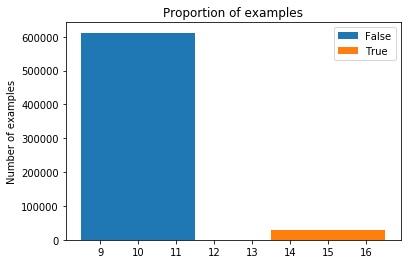

In [42]:
plt.bar(10,first_len,3, label="False")
plt.bar(15,second_len,3, label="True")
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

In [43]:
rus = RandomUnderSampler(random_state = 42)
X_rus, y_rus = rus.fit_sample(train_data, Y)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.10, random_state=42)

In [81]:
parameters = {
    'nthread': [16],
    'objective': ['binary:logistic'],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.01],
    'n_estimators': [500, 1000, 2000],
    'seed': [42]
}

classifier = XGBClassifier()
classifier = GridSearchCV(classifier, parameters,cv=3, scoring='neg_log_loss', verbose=2, 
                          n_jobs = -1, return_train_score = True)
classifier.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, nthread=16, objective=binary:logistic, seed=42 
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, nthread=16, objective=binary:logistic, seed=42 
[CV] learning_rate=0.01, max_depth=6, n_estimators=500, nthread=16, objective=binary:logistic, seed=42 
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, nthread=16, objective=binary:logistic, seed=42 
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, nthread=16, objective=binary:logistic, seed=42 
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, nthread=16, objective=binary:logistic, seed=42 
[CV] learning_rate=0.01, max_depth=6, n_estimators=2000, nthread=16, objective=binary:logistic, seed=42 
[CV] learning_rate=0.01, max_depth=6, n_estimators=2000, nthread=16, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=500, nthread=16, objective=binary:logistic, seed=42

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 279.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'nthread': [16], 'objective': ['binary:logistic'], 'max_depth': [6, 7, 8], 'learning_rate': [0.01], 'n_estimators': [500, 1000, 2000], 'seed': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=2)

In [83]:
y_pred_class = classifier.predict(X_test)

/home/daniil_chuykin/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [82]:
y_pred = classifier.predict_proba(X_test)

auc_roc = roc_auc_score(y_test, y_pred[:, 1])

print('AUC-ROC: {}'.format(auc_roc))

AUC-ROC: 0.86081558016643


In [46]:
auc_pr = average_precision_score(y_test, y_pred[:, 1])

print('AUC-PR: {}.'.format(auc_pr))

AUC-PR: 0.8544773459796424.


In [47]:
log_loss = log_loss(y_test, y_pred[:, 1])

print('Log loss: {}.'.format(log_loss))

Log loss: 0.4883538114997076.


In [95]:
recall = recall_score(y_test, y_pred_class)
print('Recall: {}.'.format(recall))

Recall: 0.8556113902847571.


In [65]:
classifier.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=16, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [50]:
classifier.best_estimator_.save_model('001.model')

In [73]:
test_case = np.array(train_data[:10])

In [69]:
test_case

array([[1, 1, 0, ..., 0, 0, 0]])

In [61]:
y_pred_class = classifier.predict(X_test)

/home/daniil_chuykin/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [62]:
y_pred_class

array([0., 1., 1., ..., 1., 1., 1.])

In [84]:
auc_roc2 = roc_auc_score(y_test, y_pred_class)

print('AUC-ROC: {}'.format(auc_roc2))

AUC-ROC: 0.7768820283595274


In [64]:
auc_pr2 = average_precision_score(y_test, y_pred_class)

print('AUC-PR: {}.'.format(auc_pr2))

AUC-PR: 0.7125814481360612.


In [52]:
y_test

array([0., 0., 1., ..., 1., 1., 1.])

In [55]:
parameters = {
    'nthread': 16,
    'objective': 'binary:logstic',
    'max_depth': 8,
    'learning_rate': 0.01,
    'n_estimators': 5000,
    'seed': 42,
    'eval_metric': ['recall', 'auc', 'log_loss']
}

# evallist = [(X_test, 'eval'), (X_train, 'train')]
# classifier2 = XGBClassifier(**parameters)

# classifier2.fit(X_train, y_train, eval_set=evallist, eval_metric='recall')
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
evallist = [(dtest,'eval'), (dtrain,'train')]
num_round = 2
bst = xgb.train(parameters, dtrain, num_round, evallist)


Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x7fdd979e16a0>>
Traceback (most recent call last):
  File "/home/daniil_chuykin/anaconda3/envs/py36/lib/python3.6/site-packages/xgboost/core.py", line 868, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


XGBoostError: b'[23:48:34] /workspace/src/metric/metric.cc:21: Unknown metric function recall\n\nStack trace returned 10 entries:\n[bt] (0) /home/daniil_chuykin/anaconda3/envs/py36/xgboost/libxgboost.so(dmlc::StackTrace()+0x42) [0x7fddae3c04a2]\n[bt] (1) /home/daniil_chuykin/anaconda3/envs/py36/xgboost/libxgboost.so(xgboost::Metric::Create(std::string const&)+0x598) [0x7fddae3f3b88]\n[bt] (2) /home/daniil_chuykin/anaconda3/envs/py36/xgboost/libxgboost.so(xgboost::LearnerImpl::Configure(std::vector<std::pair<std::string, std::string>, std::allocator<std::pair<std::string, std::string> > > const&)+0x733) [0x7fddae4717e3]\n[bt] (3) /home/daniil_chuykin/anaconda3/envs/py36/xgboost/libxgboost.so(XGBoosterUpdateOneIter+0x6e) [0x7fddae40054e]\n[bt] (4) /home/daniil_chuykin/anaconda3/envs/py36/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7fddf575aec0]\n[bt] (5) /home/daniil_chuykin/anaconda3/envs/py36/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7fddf575a87d]\n[bt] (6) /home/daniil_chuykin/anaconda3/envs/py36/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7fddf596fe2e]\n[bt] (7) /home/daniil_chuykin/anaconda3/envs/py36/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x12865) [0x7fddf5970865]\n[bt] (8) /home/daniil_chuykin/anaconda3/envs/py36/bin/python(_PyObject_FastCallDict+0x8b) [0x55959e95cd7b]\n[bt] (9) /home/daniil_chuykin/anaconda3/envs/py36/bin/python(+0x19e7ce) [0x55959e9ec7ce]\n\n'

In [ ]:
classifier2.best_estimator_.save_model('003.model')


In [99]:
y_pred2 = classifier2.predict(X_test)

recall = recall_score(y_test, y_pred2)
print('Recall: {}.'.format(recall))

Recall: 0.8556113902847571.


/home/daniil_chuykin/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [54]:
auc_pr2 = average_precision_score(y_test, y_pred_class2)

print('AUC-PR: {}.'.format(auc_pr2))

AUC-PR: 0.7125814481360612.


In [57]:
test_data = pd.read_csv('util_data.csv')
print(test_data.head(10))

   Unnamed: 0   NCT Number                                      Interventions  \
0           0  NCT02266147                                         ['sd-101']   
1           1  NCT02055924              ['ibrutinib', 'immunochemotherapies']   
2           2  NCT02395601                                       ['cpi-1205']   
3           3  NCT00162656  ['half cyclophosphamide', 'without copadm3', '...   
4           9  NCT02433795                      ['bendamustine', 'rituximab']   
5          19  NCT02060656  ['gemcitabine', 'methylprednisolone', 'rituxim...   
6          20  NCT01068392                    ['oxaliplatin', 'prednisolone']   
7          21  NCT02531308  ['metformin', 'rituximab', 'cyclophosphamide',...   
8          26  NCT00097929  ['mk0683', 'vorinostat', 'suberoylanilide hydr...   
9          27  NCT01226849  ['bortezomib', 'rituximab', 'ifosphamide', 'et...   

       Phases  
0  ['1', '2']  
1       ['1']  
2       ['1']  
3       ['3']  
4       ['2']  
5       ['2'

In [59]:
print(util_data.head(10))

     NCT Number                                      Interventions  Phases
0   NCT02266147                                           [sd-101]  [1, 2]
1   NCT02055924                  [ibrutinib, immunochemotherapies]     [1]
2   NCT02395601                                         [cpi-1205]     [1]
3   NCT00162656  [half cyclophosphamide, without copadm3, mini ...     [3]
9   NCT02433795                          [bendamustine, rituximab]     [2]
19  NCT02060656  [gemcitabine, methylprednisolone, rituximab, c...     [2]
20  NCT01068392                        [oxaliplatin, prednisolone]     [2]
21  NCT02531308  [metformin, rituximab, cyclophosphamide, doxor...     [2]
26  NCT00097929  [mk0683, vorinostat, suberoylanilide hydroxami...     [2]
27  NCT01226849  [bortezomib, rituximab, ifosphamide, etoposide...     [1]


In [73]:
type(X_test)

numpy.ndarray

In [79]:
classifier2 = xgb.Booster({'nthread': 16})
classifier2.load_model('002.model')
classifier2.predict(X_test)

AttributeError: 'numpy.ndarray' object has no attribute 'feature_names'

In [80]:
classifier2.

In [85]:
pair_data.head(5)

,NCT Number 1,NCT Number 2,Interventions 1,Interventions 2,Phases 1,Phases 2,Cosine Distance,Is Similar
0,NCT02266147,NCT02055924,[sd-101],"[ibrutinib, immunochemotherapies]","[1, 2]",[1],0.582323,1.0
1,NCT02266147,NCT02395601,[sd-101],[cpi-1205],"[1, 2]",[1],0.557370,1.0
2,NCT02266147,NCT00162656,[sd-101],"[half cyclophosphamide, without copadm3, mini ...","[1, 2]",[3],0.190261,0.0
3,NCT02266147,NCT02433795,[sd-101],"[bendamustine, rituximab]","[1, 2]",[2],0.432789,0.0
4,NCT02266147,NCT02060656,[sd-101],"[gemcitabine, methylprednisolone, rituximab, c...","[1, 2]",[2],0.294118,0.0


In [88]:
correct = pair_data.loc[(pair_data['NCT Number 1'] == 'NCT02266147') & (pair_data['Is Similar'] == 1)]

In [91]:
correct.shape

(116, 8)

In [89]:
predicted = ['NCT00097929', 'NCT00169468', 'NCT01197560', 'NCT01481129', 'NCT01423539', 'NCT00474188', 'NCT01287741', 'NCT02077166', 'NCT02670616', 'NCT02596971', 'NCT01852435', 'NCT02600897', 'NCT01414855', 'NCT00211276', 'NCT02282358', 'NCT02564744', 'NCT01691898', 'NCT02049541', 'NCT02443077', 'NCT02436707', 'NCT02529852', 'NCT02636322', 'NCT02073097', 'NCT00764517', 'NCT00667615', 'NCT02611323', 'NCT00703664', 'NCT02624986', 'NCT02623920', 'NCT02367040', 'NCT01992653', 'NCT01120834', 'NCT00974792', 'NCT00875056', 'NCT01209130', 'NCT01290549', 'NCT02055820', 'NCT01258998', 'NCT01500538', 'NCT00253630', 'NCT00720876', 'NCT00994500', 'NCT00871546', 'NCT00825149']

In [90]:
true_counter = 0
for i in correct['NCT Number 2']:
    for j in predicted:
        if i == j:
            true_counter += 1
print(true_counter)

22


In [56]:
from sklearn.linear_model import LogisticRegressionCV

In [57]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split

In [60]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
LR = LogisticRegressionCV(penalty='l2', n_jobs = -1)
cv = kf.split(X_train,y_train)
LR_scores_b = cross_val_score(LR, X_train, y_train, scoring='roc_auc', cv=cv)
print('Logistic Regression recall: {0:.3f} ± {1:.3f}'.format(LR_scores_b.mean(), LR_scores_b.std()) )

Logistic Regression recall: 0.864 ± 0.002


In [65]:
with open('LR_model.pkl', 'wb') as fid:
    pickle.dump(LR, fid)  